In [1]:
import json
import sys
import torch
import os
import pickle, gzip
import json
import pandas as pd
import matplotlib.pyplot as plt
# !pip install --upgrade orjson
import orjson
sys.path.insert(0, '/home/sulcan/Documents/ipac-logbook/code/')
from mmd import *
from glob import glob
from tqdm.notebook import tqdm
from pprint import pprint
# from trl import SFTConfig, SFTTrainer
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForLanguageModeling
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import BitsAndBytesConfig
from transformers import TextStreamer

from unsloth import FastLanguageModel
from datasets import Dataset, load_dataset
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import numpy as np

base_model_id = "unsloth/llama-3-8b-Instruct-bnb-4bit"
model_id = base_model_id
device = torch.device('cuda:0')
gd = lambda x,i : x[list(x.keys())[i]]
data_folder = '/home/sulcan/Documents/chatqcd/data/'

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [2]:
# model_id = '/home/sulcan/Documents/chatqcd/models/results/checkpoint-20000/'
model_id = '/home/sulcan/Documents/chatqcd/models/results/checkpoint-40000/'
# model_id = '/home/sulcan/Documents/chatqcd/models/results/checkpoint-45000/'

### Loading model

In [3]:
model, tokenizer = FastLanguageModel.from_pretrained(model_name=model_id, dtype = None, load_in_4bit=True)

==((====))==  Unsloth 2024.8: Fast Llama patching. Transformers = 4.44.2.
   \\   /|    GPU: Tesla V100S-PCIE-32GB. Max memory: 31.733 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.0+cu121. CUDA = 7.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.27.post2. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Unsloth 2024.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [4]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
# q = "Where is DESY ALPSII experiment? Which city is it? Is it in USA?"
# q = "What are current achievements of DESY ALPSII?"
# q = "Give me list of research institutes that research about axion and dark matter."
# q = "Give me an exact value of \[alpha_s]\ and accuracy from ALICE"
# q = "How many combinations of gluon colours does exist?"
# q = "What is the most recent PDG value of the strong coupling?"
# q = "How would you prove the existence of dark matter with axion?"
# q = "What is Primakoff effect and how does it fit to the problem of axion?"
# q = "What is TMDlib?"
# q = "When was HERA decomissioned?"
# q = "What was the PDG value of the strong coupling alpha_s in 2010?"
# q = "Which factorization scale was chosen for the QCD interpretation of the measurement of inclusive jet cross section at 13 TeV by the CMS Collaboration?"
# q = "What are possible choices of factorization scale in QCD interpretation of inclusive jet cross section measurements at CMS and ATLAS?"
# q = "Give me the references of inclusive jet cross section measurements by CMS and ATLAS."
# q = "Up to which energy scale can one use tau hadronic spectral functions to determine the strong coupling constant? Can you explain why?"
# q = "How many gluons exist?"

# q = 'What causes color confinement in QCD?'
# q = 'How does the QCD coupling constant change with energy scale?'
# q = 'What is a glueball in QCD?'
# q = 'Why is QCD challenging to solve in the low-energy regime?'
q = "What's the QCD vacuum's θ parameter value?"
# q = "What's the beta function's leading coefficient in QCD?"


pa = 'Make the answer as short as possible.'
# pa = "Make the answer as detailed as possible"
q = f'{pa}. {q}'

q = tokenizer.apply_chat_template([
    {'role' : 'system', 'content' : pa},
    {'role' : 'user', 'content' : q}], tokenize= False)

inputs = tokenizer(q, return_tensors = "pt")
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 256, temperature = 0.5)

<|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

Make the answer as short as possible.<|eot_id|><|start_header_id|>user<|end_header_id|>

Make the answer as short as possible.. What's the QCD vacuum's θ parameter 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


value?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The QCD vacuum's θ parameter is zero.<|eot_id|>


## Likelihood of output

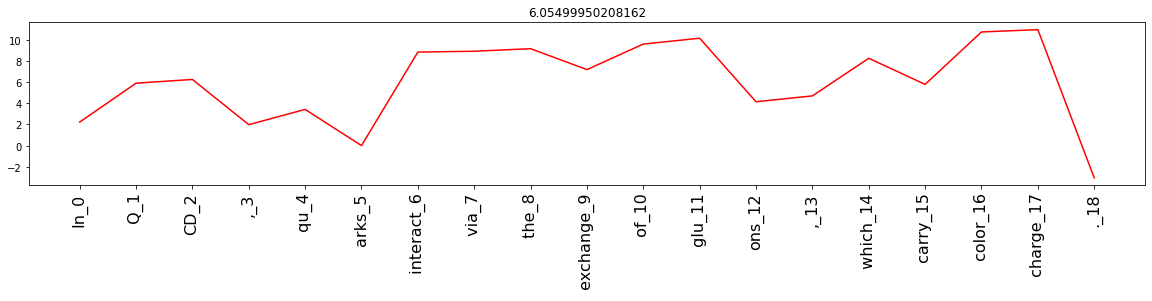

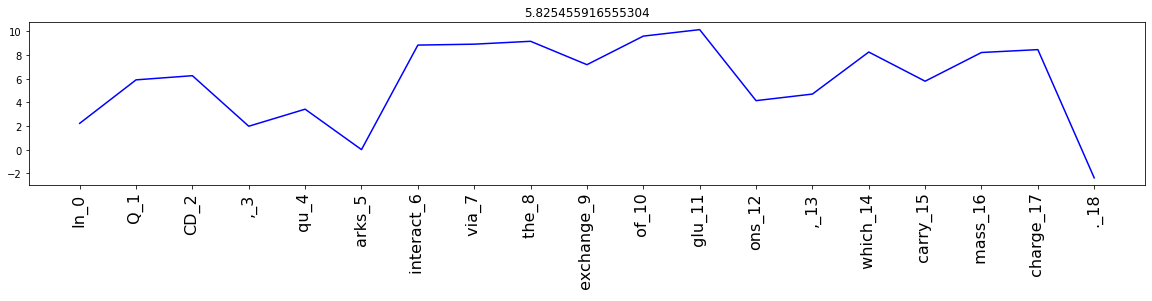

[{'logit': 2.224609375, 'token': 'In'},
 {'logit': 5.89453125, 'token': ' Q'},
 {'logit': 6.24609375, 'token': 'CD'},
 {'logit': 1.9814453125, 'token': ','},
 {'logit': 3.419921875, 'token': ' qu'},
 {'logit': 0.00885772705078125, 'token': 'arks'},
 {'logit': 8.828125, 'token': ' interact'},
 {'logit': 8.90625, 'token': ' via'},
 {'logit': 9.1484375, 'token': ' the'},
 {'logit': 7.17578125, 'token': ' exchange'},
 {'logit': 9.5859375, 'token': ' of'},
 {'logit': 10.1328125, 'token': ' glu'},
 {'logit': 4.140625, 'token': 'ons'},
 {'logit': 4.6953125, 'token': ','},
 {'logit': 8.2421875, 'token': ' which'},
 {'logit': 5.78125, 'token': ' carry'},
 {'logit': 10.7265625, 'token': ' color'},
 {'logit': 10.9453125, 'token': ' charge'},
 {'logit': -3.0390625, 'token': '.'}]
[{'logit': 2.224609375, 'token': 'In'},
 {'logit': 5.89453125, 'token': ' Q'},
 {'logit': 6.24609375, 'token': 'CD'},
 {'logit': 1.9814453125, 'token': ','},
 {'logit': 3.419921875, 'token': ' qu'},
 {'logit': 0.008857727

In [22]:
def get_logits(q):
    inputs = tokenizer(q, return_tensors = "pt")
    outputs = model(**inputs)
    logits = outputs.logits

    seq_logits = []
    for i in range(1,inputs['input_ids'].numel()):
        pos = inputs['input_ids'][0,i]
        token = tokenizer.decode([pos])
        logits_ = logits[0,i,pos].item()
        seq_logits.append({'token' : token, 'logit' : logits_})
    return seq_logits

plt.rcParams["figure.figsize"] = (20,3)
# q = "ALPSII is at DESY."
# q = "Primakoff effect is used for axions."
q = "How many gluons exist? 8"
q = 'In QCD, quarks interact via the exchange of gluons, which carry color charge.'
logits1 = get_logits(q)
# q = "ALPSII is at CERN."
# q = "Primakoff effect is used for bosons."
q = "How many gluons exist? 9"
q = 'In QCD, quarks interact via the exchange of gluons, which carry mass charge.'
logits2 = get_logits(q)

logit1_max = max([l['logit'] for l in logits1])
logit2_max = max([l['logit'] for l in logits2])
both_max = max([logit1_max, logit2_max])


plt.plot([l['token'] + f'_{i}' for i,l in enumerate(logits1)], [l['logit'] for l in logits1],'r-')
plt.title(str(np.nanmean(np.array([l['logit'] for l in logits1]))))
# plt.ylim([0,both_max])
plt.xticks(rotation = 90, fontsize = 16)
plt.show()

plt.plot([l['token'] + f'_{i}' for i,l in enumerate(logits2)], [l['logit'] for l in logits2],'b-')
plt.title(str(np.nanmean(np.array([l['logit'] for l in logits2]))))
# plt.ylim([0,both_max])
plt.xticks(rotation = 90, fontsize = 16)
plt.show()

pprint(logits1)
pprint(logits2)

[{'logit': 2.234375, 'token': 'In'},
 {'logit': 9.2421875, 'token': ' Quantum'},
 {'logit': 9.3828125, 'token': ' Chrom'},
 {'logit': 6.046875, 'token': 'odynamics'},
 {'logit': 1.8828125, 'token': ' ('},
 {'logit': 10.5625, 'token': 'Q'},
 {'logit': 8.1015625, 'token': 'CD'},
 {'logit': 0.75634765625, 'token': '),'},
 {'logit': 4.0625, 'token': ' qu'},
 {'logit': 0.3056640625, 'token': 'arks'},
 {'logit': 8.6171875, 'token': ' interact'},
 {'logit': 8.546875, 'token': ' via'},
 {'logit': 9.4609375, 'token': ' the'},
 {'logit': 7.46875, 'token': ' exchange'},
 {'logit': 9.5078125, 'token': ' of'},
 {'logit': 9.84375, 'token': ' glu'},
 {'logit': 4.30859375, 'token': 'ons'},
 {'logit': 4.78125, 'token': ','},
 {'logit': 7.3671875, 'token': ' which'},
 {'logit': 5.75390625, 'token': ' carry'},
 {'logit': 11.1171875, 'token': ' color'},
 {'logit': 11.0390625, 'token': ' charge'},
 {'logit': -3.64453125, 'token': '.'}]
[{'logit': 2.234375, 'token': 'In'},
 {'logit': 9.2421875, 'token': ' Q

# Gradio

In [7]:
import time
import gradio as gr
pattern = r"(?<=<\|end\|><\|assistant\|>)\s*(.*?)\s*(?=<\|end\|><\|endoftext\|>)"

def llm_call(message, history):
    inputs = tokenizer(message, return_tensors = "pt")
    output = model.generate(**inputs, max_new_tokens = 512, temperature = 0.7)
    result = tokenizer.decode(output.tolist()[0],skip_special_tokens=False)
    result = re.search(pattern, result)
    extracted_text = ''
    if not result is None:
        extracted_text = result.group(1)
    yield extracted_text 


demo = gr.ChatInterface(llm_call)

if __name__ == "__main__":
    demo.launch(share=True)


ModuleNotFoundError: No module named 'gradio'

# Statisics about training data

In [ ]:
with gzip.open(f'{data_folder}/arxiv_with_prompts.pickle.gzip','rb') as f:
    data_mmd = pickle.load(f)

In [ ]:
num_tokens = {}

for k in tqdm(data_mmd):
    num_tokens[k] = len(tokenizer.encode(data_mmd[k]['raw']))